# Liquid freshwater content anomaly in the SPNA and NSEA from ECCOv4r4

In [6]:
import numpy as np
import xarray as xr

import shapely
import geopandas as gpd
import salem

import matplotlib.pyplot as plt
%matplotlib inline

### Load salinity from ECCOv4r4

In [7]:
ecco = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_interp_salt.nc')

In [8]:
south,north,west,east = 40,90,-110,45

tstart = '1992-01-01'
tend = '2017-12-31'

In [9]:
psal_ec = ecco.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

### Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [10]:
psal_ref = 35.0
f_ec = (psal_ref - psal_ec)/psal_ref
h_fw_ec = (f_ec * ecco.dz).sum('depth')

### Spatially integrate to obtain the liquid freshwater content (LFWC)
$$LFWC = \oint h_{fw}\; dA$$

In [11]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [12]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]

In [13]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
h_fw_ec_spna = h_fw_ec.salem.roi(shape=gdf_spna.loc[[0]])
h_fw_ec_nsea = h_fw_ec.salem.roi(shape=gdf_nsea.loc[[0]])

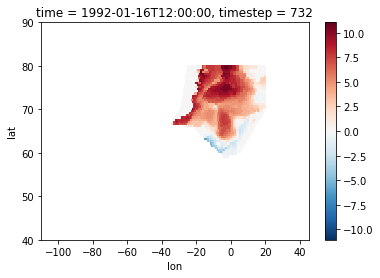

In [15]:
h_fw_ec_nsea[0].plot()

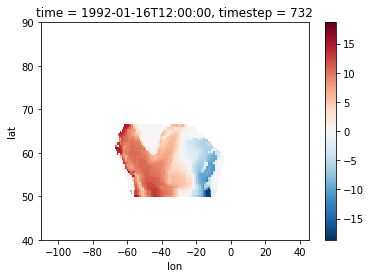

In [16]:
h_fw_ec_spna[0].plot()

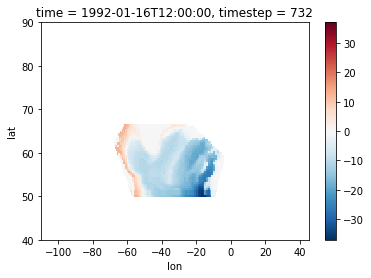

In [14]:
# Sref = 34.8

In [17]:
Vfw_spna_ec = (h_fw_ec_spna * ecco.area).sum(dim=['lat','lon'])
Vfw_nsea_ec = (h_fw_ec_nsea * ecco.area).sum(dim=['lat','lon'])

# Convert from m^3 to km^3
Vfw_spna_ec = Vfw_spna_ec*1e-9
Vfw_nsea_ec = Vfw_nsea_ec*1e-9

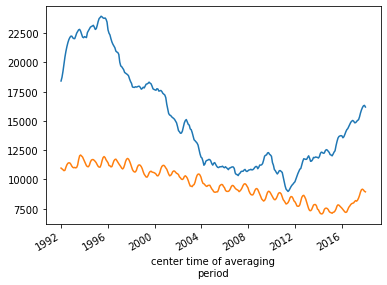

In [18]:
Vfw_spna_ec.plot()
Vfw_nsea_ec.plot()

In [20]:
ds_spna = Vfw_spna_ec.to_dataset(name='lfwc')
ds_nsea = Vfw_nsea_ec.to_dataset(name='lfwc')

In [21]:
ds_spna.to_netcdf('/mnt/efs/data/ecco/eccov4r4_lfwc_spna_monthly.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})

In [22]:
ds_nsea.to_netcdf('/mnt/efs/data/ecco/eccov4r4_lfwc_nsea_monthly.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})

In [12]:
# Anomaly
Vfw_spna_ec_anom = Vfw_spna_ec - Vfw_spna_ec.mean('time')
Vfw_nsea_ec_anom = Vfw_nsea_ec - Vfw_nsea_ec.mean('time')

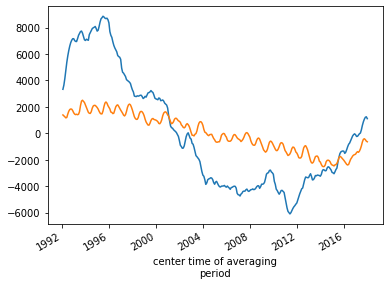

In [13]:
Vfw_spna_ec_anom.plot()
Vfw_nsea_ec_anom.plot()

In [14]:
ds_spna = Vfw_spna_ec_anom.to_dataset(name='lfwc')
ds_nsea = Vfw_nsea_ec_anom.to_dataset(name='lfwc')

In [15]:
ds_spna.to_netcdf('/mnt/efs/data/ecco/eccov4r4_lfwc_spna_monthly_anom.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})

In [16]:
ds_nsea.to_netcdf('/mnt/efs/data/ecco/eccov4r4_lfwc_nsea_monthly_anom.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})